#### Importing Library 

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import peakutils
## matlab imresize
## https://github.com/fatheral/matlab_imresize
#from imresize import imresize
from tqdm.notebook import tqdm
from math import ceil, floor
#import torch

#### Path

In [2]:
## Image source and destination Path 
source_path="/home/advenio/Desktop/r-d/Diagnosable_Non-Diagnosable/Aug_Data_D_ND/Retake/Retake_8.4.20"
destination_path="/home/advenio/Desktop/r-d/Diagnosable_Non-Diagnosable/Aug_Data_D_ND/Retake/cropped_retake"

#### Binary Image Conversion function 

In [3]:
## This function return binary of input image
def binary_image(image):
    ##Conveting Image to grayscale 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ## finding histogram
    hist,binn = np.histogram(gray,256,[0,256])
    # Invert the histogram (minima will become maxima and vice versa)
    hist_inv = hist.max() - hist
    #print(hist_inv)    
    indexes = peakutils.indexes(hist_inv.flatten())
    #print(indexes)
    indexes=np.sort(indexes)
    indexes = peakutils.indexes(hist_inv.flatten())
    indexes=np.sort(indexes)
    thresh_vals = np.linspace(0, 256, num=256)
    ## Threshold value
    thresh_mask = thresh_vals[indexes[0]]
    ## Binary thresholding
    ret, thresh = cv2.threshold(gray,thresh_mask,255,cv2.THRESH_BINARY)
    ### morphological opening operations are performed here 
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    return thresh    

#### Checking orientation

In [4]:
""" This function return the angle,x,y-coordinates with width and height 
of bounding box which is used for cropping and re-orentation of Images """

def checking_orientation_of_image(thresh,image):  
    ## Finding Contour using binary images
    contours,hierarchy= cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ### Contour area
    contours_area = [cv2.contourArea(contour) for contour in contours]
    ## index of max countour area
    max_contour_area_index = np.array(contours_area).argmax()    
    #print(max_contour_area_index)
    ## x,y-co-ordinate axis, w-width, h-height
    x, y, w, h = cv2.boundingRect(contours[max_contour_area_index])
    #print(x,y,w,h)
    ## creating a mask which having same dimension as image size  
    mask = np.zeros_like(image)
    ## Drawing Contour 
    mask = cv2.drawContours(mask,contours,max_contour_area_index,(1,1,1),-1)
    ### finding angle of max_contour_area
    rot_box = cv2.minAreaRect(contours[max_contour_area_index])
    ## stroring the value of angle in variable angle 
    angle=int(rot_box[2])
    
    return angle,x,y,w,h,mask   
    

#### Image Rotation 

In [5]:
### This function return re-oriented image 
def rotateImage(image, angle):
    row = image.shape[0]
    col=image.shape[1]
    center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col, row), flags=cv2.INTER_CUBIC)
    #new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image


#### Cropping black area from fundus Images

In [ ]:
### Cropping black area from image using binary thresholding and saving images to defined locations.
##Progress bar 
with tqdm (total=len(os.listdir(source_path))) as pbar:       
    for count,image_path in enumerate(os.listdir(source_path)):
        try:
            #for taking only image file name without extensions
            image_name_str=image_path[:-4]
            #Reading image
            image=cv2.imread(source_path+'/'+image_path)
            thresh = binary_image(image)
            #plt.imshow(thresh)
            angle,x,y,w,h,mask=checking_orientation_of_image(thresh,image)

            ##Re-orentation of image
            ##angle- 0 means image is oriented
            if angle < -10: 
                if angle==-90:

                    mask=mask[y:y+h,x:x+w]
                    foreground_image = image[y:y+h, x:x+w]
                    cropped_image=cv2.multiply(foreground_image,mask) 
                    if cropped_image.shape[0]==cropped_image.shape[1]:
                        pass
                    elif cropped_image.shape[0]>cropped_image.shape[1]:
                        #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[0],cropped_image.shape[0]))
                        cropped_image=cv2.resize(cropped_image,(cropped_image.shape[0],cropped_image.shape[0]),interpolation=cv2.INTER_CUBIC)

                    else:
                        #pass
                        #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[1],cropped_image.shape[1]))
                        cropped_image=cv2.resize(cropped_image,(cropped_image.shape[1],cropped_image.shape[1]),interpolation=cv2.INTER_CUBIC)


                else:
                    mask=mask[y:y+h,x:x+w]
                    foreground_image = image[y:y+h, x:x+w]
                    cropped_image=cv2.multiply(foreground_image,mask)     
                    reorented_image=rotateImage(cropped_image,90+(angle))
                    ## Cropping after rotation 
                    _,x,y,w,h,_=checking_orientation_of_image(binary_image(reorented_image),reorented_image)
                    cropped_image = reorented_image[y:y+h, x:x+w]   
                    if cropped_image.shape[0]==cropped_image.shape[1]:
                        pass 
                    elif cropped_image.shape[0]>cropped_image.shape[1]:
                        #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[0],cropped_image.shape[0]))
                        cropped_image=cv2.resize(cropped_image,(cropped_image.shape[0],cropped_image.shape[0]),interpolation=cv2.INTER_CUBIC)

                    else:
                        #pass
                        #cropped_image = imresize(cropped_image,output_shape=(cropped_image.shape[1],cropped_image.shape[1]))
                        cropped_image=cv2.resize(cropped_image,(cropped_image.shape[1],cropped_image.shape[1]),interpolation=cv2.INTER_CUBIC)


            else:             
                #print(angle)
                mask=mask[y:y+h,x:x+w]
                foreground_image = image[y:y+h, x:x+w]
                cropped_image=cv2.multiply(foreground_image,mask)     
                reorented_image=rotateImage(cropped_image,angle)
                _,x,y,w,h,_=checking_orientation_of_image(binary_image(reorented_image),reorented_image)
                cropped_image = reorented_image[y:y+h, x:x+w]
                if cropped_image.shape[0]==cropped_image.shape[1]:
                    pass 
                elif cropped_image.shape[0]>cropped_image.shape[1]:
                        #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[0],cropped_image.shape[0]))
                        cropped_image=cv2.resize(cropped_image,(cropped_image.shape[0],cropped_image.shape[0]),interpolation=cv2.INTER_CUBIC)

                else:
                    #pass
                    #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[1],cropped_image.shape[1]))
                    cropped_image=cv2.resize(cropped_image,(cropped_image.shape[1],cropped_image.shape[1]),interpolation=cv2.INTER_CUBIC)

            ## updating progress bar
            pbar.update(1)
            #writing image file to disk
            #cropped_image=cv2.resize(cropped_image,(512,512))

            cv2.imwrite(f'{destination_path}/{image_name_str}_cropped.png',cropped_image)
            #print(image_name_str)
        except:
            print(image_name_str)
            
print("Done!!!!")        

Thumb


In [ ]:
destination_path="/home/advenio/Desktop/r-d/Images"

In [ ]:
### Cropping black area from image using binary thresholding and saving images to defined locations.
##Progress bar 
def preprocess(input_image):   
    image=cv2.imread(input_image)
    thresh = binary_image(image)
    #plt.imshow(thresh)
    angle,x,y,w,h,mask=checking_orientation_of_image(thresh,image)
    ##Re-orentation of image
    ##angle- 0 means image is oriented
    if angle < -10: 
        if angle==-90:

            mask=mask[y:y+h,x:x+w]
            foreground_image = image[y:y+h, x:x+w]
            #cropped_image=foreground_image
            cropped_image=cv2.multiply(foreground_image,mask) 
            if cropped_image.shape[0]==cropped_image.shape[1]:
                pass
            elif cropped_image.shape[0]>cropped_image.shape[1]:
                #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[0],cropped_image.shape[0]))
                cropped_image=cv2.resize(cropped_image,(cropped_image.shape[0],cropped_image.shape[0]),interpolation=cv2.INTER_CUBIC)

            else:
                #pass
                #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[1],cropped_image.shape[1]))
                cropped_image=cv2.resize(cropped_image,(cropped_image.shape[1],cropped_image.shape[1]),interpolation=cv2.INTER_CUBIC)


        else:
            mask=mask[y:y+h,x:x+w]
            foreground_image = image[y:y+h, x:x+w]
            #cropped_image=foreground_image
            cropped_image=cv2.multiply(foreground_image,mask)     
            reorented_image=rotateImage(cropped_image,90+(angle))
            ## Cropping after rotation 
            _,x,y,w,h,_=checking_orientation_of_image(binary_image(reorented_image),reorented_image)
            cropped_image = reorented_image[y:y+h, x:x+w]   
            if cropped_image.shape[0]==cropped_image.shape[1]:
                pass 
            elif cropped_image.shape[0]>cropped_image.shape[1]:
                #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[0],cropped_image.shape[0]))
                cropped_image=cv2.resize(cropped_image,(cropped_image.shape[0],cropped_image.shape[0]),interpolation=cv2.INTER_CUBIC)

            else:
                #pass
                #cropped_image = imresize(cropped_image,output_shape=(cropped_image.shape[1],cropped_image.shape[1]))
                cropped_image=cv2.resize(cropped_image,(cropped_image.shape[1],cropped_image.shape[1]),interpolation=cv2.INTER_CUBIC)


    else:             
        #print(angle)
        mask=mask[y:y+h,x:x+w]
        foreground_image = image[y:y+h, x:x+w]
        cropped_image=cv2.multiply(foreground_image,mask)
        #cropped_image=foreground_image
        reorented_image=rotateImage(cropped_image,angle)
        _,x,y,w,h,_=checking_orientation_of_image(binary_image(reorented_image),reorented_image)
        cropped_image = reorented_image[y:y+h, x:x+w]
        if cropped_image.shape[0]==cropped_image.shape[1]:
            pass 
        elif cropped_image.shape[0]>cropped_image.shape[1]:
                #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[0],cropped_image.shape[0]))
                cropped_image=cv2.resize(cropped_image,(cropped_image.shape[0],cropped_image.shape[0]),interpolation=cv2.INTER_CUBIC)

        else:
            #pass
            #cropped_image = imresize(cropped_image, output_shape=(cropped_image.shape[1],cropped_image.shape[1]))
            cropped_image=cv2.resize(cropped_image,(cropped_image.shape[1],cropped_image.shape[1]),interpolation=cv2.INTER_CUBIC)


    #writing image file to disk
    cv2.imwrite(f'{destination_path}/_cropped.png',cropped_image)
    #print(image_name_str)
print("Done!!!!")        

In [20]:
input_image="/home/advenio/Desktop/r-d/Images/Disha Eye Hospital_Barrackpore_Topcon_{0A39ED87-69D3-4695-8CD6-F2E82F0872DB}.png"
preprocess(input_image)

#### Only Cropping 

In [1]:
# ### Cropping black area from image using binary thresholding and saving images to defined locations.
# ##Progress bar 
# with tqdm (total=len(os.listdir(source_path))) as pbar:       
#     for count,image_path in enumerate(os.listdir(source_path)):
#         # empty string variable
#         image_name_str=image_path[:-4]
#         # for taking only image file name without extensions
#         #Reading image
#         image=cv2.imread(source_path+'/'+image_path)
#         thresh = binary_image(image)
#         #plt.imshow(thresh)
#         angle,x,y,w,h,mask=checking_orientation_of_image(thresh,image)
        
#         mask=mask[y:y+h,x:x+w]
#         foreground_image = image[y:y+h, x:x+w]
#         ## For resize
#         #foreground_image=cv2.resize(foreground_image,(512,512))
#         #cropped_image=cv2.multiply(foreground_image,mask) 
       
#         ## updating progress bar
#         pbar.update(1)
#         #writing image file to disk
#         cv2.imwrite(f'{destination_path}/{image_name_str}_cropped.png',foreground_image)
#         #print(image_name_str)
# print("Done!!!!")        

In [18]:
from field_of_view_cropping_preprocessing import preprocess 

In [19]:
Path="/home/advenio/Desktop/r-d/new_clf_DR/After_Clahe/Valid/OTHERS/1.2.276.0.75.2.1.20.0.3.120710183558015.1100494.1122.png_hsv_img_clahe.png_rotate166.png"

In [27]:
img=cv2.imread(Path)

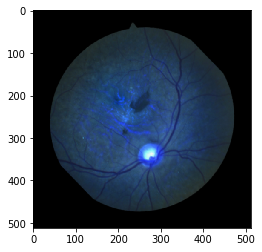

In [28]:
plt.imshow(img)

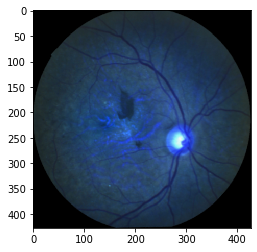

In [29]:
plt.imshow(preprocess(Path))